In [1]:
import pickle
from matplotlib import pyplot 

In [2]:
!pwd

/root/nlp-summarization


In [3]:
hist = pickle.load(open( 'history.pkl' , "rb" ))

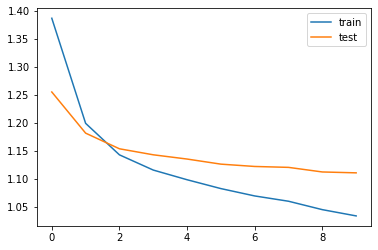

In [4]:

pyplot.plot(hist['loss'], label='train') 
pyplot.plot(hist['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [6]:
import numpy as np
import pandas as pd 
import pickle
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
#cleanfilename = 'cleandatamini.pkl'
cleanfilename = 'cleandata.pkl'
modelfilename = 'model.json'
weightsfilename = 'model.h5'
historyfilename = 'history.pkl'


# In[2]:


print('Loading training data.')


# In[3]:


clean_data = pickle.load( open( 'cleandata.pkl' , "rb" ) )


# In[4]:


print('Training data loaded. Shape is', clean_data.shape)


# In[27]:


print('Starting to build the embedding index.')


# In[28]:


embeddings_index = {}
f = open('data/glove/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


# In[29]:


print('Built embeddings index. Found %s word vectors.' % len(embeddings_index))


# In[30]:


def doc2seq(texts, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM):
    tokenizer = Tokenizer(filters='"#$%&()*+-/<=>@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return data, embedding_matrix, word_index, index_word


# In[31]:


print('Building text')


# In[32]:


MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 300
data = clean_data.text

x_data, encoder_emb, x_word_index, x_index_word = doc2seq(data, MAX_TEXT_LENGTH, EMBEDDING_DIM)


# In[33]:


print('Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are', 
      list(map(lambda a:len(a), [x_data, encoder_emb, x_word_index, x_index_word ])))


# In[34]:


print('Building headlines ')


# In[35]:


MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
data = clean_data.headline

y_data, decoder_emb, y_word_index, y_index_word = doc2seq(data, MAX_HEADLINE_LENGTH, EMBEDDING_DIM)


# In[36]:


print('Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are', 
      list(map(lambda a:len(a), [y_data, decoder_emb, y_word_index, y_index_word])))


# In[37]:


x_train, x_test_temp, y_train, y_test_temp = train_test_split(x_data, y_data, 
                                                            test_size=0.3, random_state=0) 


# In[38]:


x_dev, x_test, y_dev, y_test = train_test_split(x_test_temp, y_test_temp, 
                                                            test_size=0.33, random_state=0) 


# In[39]:


print('Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are', 
     list(map(len, [x_train, y_train,x_dev, y_dev, x_test, y_test])))


Loading training data.
Training data loaded. Shape is (1387290, 2)
Starting to build the embedding index.
Built embeddings index. Found 400000 word vectors.
Building text
Found 212813 unique tokens.
Text built. Lengths of x_data, encoder_emb, x_word_index, x_index_word are [1387290, 212814, 212813, 212813]
Building headlines 
Found 78682 unique tokens.
Headlines built. Lengths of y_data, decoder_emb, y_word_index, y_index_word are [1387290, 78683, 78682, 78682]
Test Train Dev split done. Length of x_train, y_train,x_dev, y_dev, x_test, y_test are [971103, 971103, 278845, 278845, 137342, 137342]


In [7]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Embedding
from tensorflow.keras.models import Model
from attention_keras.layers.attention import AttentionLayer

In [8]:
MAX_TEXT_LENGTH = 100
MAX_HEADLINE_LENGTH = 30
EMBEDDING_DIM = 300
hidden_units = 400

In [9]:
def create_model():
    enc_embedding_layer = Embedding(len(x_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[encoder_emb],
                                input_length=MAX_TEXT_LENGTH,
                                trainable=False,
                                name='EncoderEmbeddingLayer')


    dec_embedding_layer = Embedding(len(y_word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[decoder_emb],
                                input_length=MAX_HEADLINE_LENGTH,
                                trainable=False,
                                name='DecoderEmbeddingLayer')


    # Encoder 

    # Encoder input 
    # 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
    encoder_inputs = Input(shape=(MAX_TEXT_LENGTH,), name="EncoderInput") 
    enc_emb = enc_embedding_layer(encoder_inputs) 


    #LSTM 1 
    encoder_lstm1 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM1') 
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    #LSTM 2 
    encoder_lstm2 = LSTM(hidden_units,return_sequences=True,return_state=True, name='EncLSTM2') 
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    #LSTM 3 
    encoder_lstm3=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM3') 
    encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

    #LSTM 4 
    encoder_lstm4=LSTM(hidden_units, return_state=True, return_sequences=True, name='EncLSTM4') 
    encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3) 

    # Decoder 

    decoder_inputs = Input(shape=(None,), name = 'DecoderInput') 
    #dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
    dec_emb = dec_embedding_layer(decoder_inputs) 

    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='DecLSTM1') 
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    #Attention Layer
    attn_layer = AttentionLayer(name='attention_layer') 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    #Dense layer
    decoder_dense = TimeDistributed(Dense(len(y_word_index)+1, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)




In [10]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    parallel_model = create_model() 
    parallel_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

parallel_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
EncoderEmbeddingLayer (Embeddin (None, 100, 300)     63844200    EncoderInput[0][0]               
__________________________________________________________________________________________________
EncLSTM1 (LSTM)                 [(None, 100, 400), ( 1121600     EncoderEmbeddingLayer[0][0]      
__________________________________________________________________________________________________
EncLSTM2 (LSTM)                 [(None, 100, 400), ( 1281600     EncLSTM1[0][0]                   
______________________________________________________________________________________________

In [11]:
parallel_model.load_weights("model_fd_111819_400units_punct.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
encoder_inputs = parallel_model.input[0]
encoder_model = Model(inputs = encoder_inputs, outputs = parallel_model.get_layer('EncLSTM4').output)

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LENGTH,hidden_units))

# Get the embeddings of the decoder sequence
dec_emb2= parallel_model.get_layer('DecoderEmbeddingLayer')(parallel_model.input[1])

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = parallel_model.get_layer('DecLSTM1')(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = parallel_model.get_layer('attention_layer')([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = parallel_model.layers[-1](decoder_inf_concat) #This is the time distributed layer

# Final decoder model
decoder_model = Model(
[parallel_model.input[1]] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [23]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0 ):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [24]:
def get_top_beam_search_sentences(input_seq, beam=3):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    top_sentences = {}
    
    def top_tokens(last_token, out, h, c):
        output_tokens, h_new, c_new = decoder_model.predict([[last_token]] + [out, h, c])
        top_token_indexes = np.argsort(output_tokens[0, -1, :])[-beam:]
        top_probabilities = output_tokens[0,-1, top_token_indexes]
        return top_token_indexes, top_probabilities, h_new, c_new
        
    #first set of tokens when feeding encoder states and 0 as the first token to the decoder.
    first_tokens, first_probabilities, h, c = top_tokens(0, e_out, e_h, e_c)
    for first_token, first_probability in zip(first_tokens, first_probabilities):
        #initialize top sentences, their corresponding probabilities and states
        top_sentences[y_index_word.get(first_token, '')] = (first_probability, h, c)
    
    
    #loop to iterate over next tokens
    len = 1
    while len < MAX_HEADLINE_LENGTH:
        candidate_sentences = {}
        for sentence, (probability, h, c) in top_sentences.items():
            last_word = sentence.split()[-1] #pick the last word in the sentence as next word
            if(last_word != '.'):
                token = y_word_index.get(last_word, 0) 
                next_tokens, next_probabilities, h_next, c_next = top_tokens(token, e_out, h, c)
                for next_token, next_probability in zip(next_tokens, next_probabilities):
                    new_sentence = sentence.strip() + ' ' + y_index_word.get(next_token, '')
                    candidate_sentences[new_sentence.strip()] = (probability * next_probability, h_next, c_next)
            else:
                candidate_sentences[sentence] = (probability, h, c)

        #print('Candidate sentences')
        #print(candidate_sentences.keys())
        
        #remove low probability candidates
        low_probability_candidates = sorted(candidate_sentences, key=lambda k: candidate_sentences.get(k)[0])[:-beam]
        for low_probability_candidate in low_probability_candidates:
            candidate_sentences.pop(low_probability_candidate)
        
        #Now all candidates left have highest probabilities.
        top_sentences = candidate_sentences
        len = len + 1
        #print('Sentences at the bottom of the loop')
        #print(top_sentences.keys())
        

    return top_sentences

def beam_decode_sequence(input_seq, beam=3):
    top_sentences_obj = get_top_beam_search_sentences(input_seq.reshape(1,-1), beam)
    l = [(sen, prob) for sen, (prob, _, _) in top_sentences_obj.items()]
    return sorted(l, key = lambda x:-x[1])[0][0]

In [25]:
def return_decode(x): 
    gen_output = decode_sequence(x.reshape(1,-1)).split()
    candidate = [item for item in gen_output if (item!="." and item!="")] 
    return(candidate)

def return_summary(x): 
    gen_summary = seq2summary(x).split()
    reference =  [item for item in gen_summary if (item!="." and item!="")] 
    return(reference)

In [26]:
############
##### helpful functions to help with formatting when printing: 
############
def printmd(string):
    display(Markdown(string)) #just a pretty print 

###############
##### function for rouge 
############### 
# PULL METRICS.PY FILE!! 
from metrics import rouge_n_sentence_level
# metrics.py is taken from https://github.com/neural-dialogue-metrics/rouge

# Other useful links to keep in mind: 
# https://stackoverflow.com/questions/38045290/text-summarization-evaluation-bleu-vs-rouge

def calc_indiv_rouge(id_text, text_df, headline_df, rouge_n): 
    # This function will take the following as inputs: 
    # id_text: the index you are interested in 
    # gen_text_df: the sequences that hold the full text 
    # headline_df: the sequences that hold the headline text 
    
    # -- Step 1: generate the decoded sequence from a given sample of text
    gen_output = decode_sequence(text_df[id_text].reshape(1,-1))
    split_output = gen_output.split(" ")
    candidate = [item for item in split_output if (item!="." and item!="")] #get rid of empty spaces and periods 
    # -- Step 2: generate the true headline summary from our labelled headline text
    gen_ref = seq2summary(headline_df[id_text])
    split_ref = gen_ref.split(" ")
    #get rid of empty spaces and periods (there shouldn't be any as we already cleaned the headline, but just in case)
    reference = [item for item in split_ref if (item!="." and item!="")] 
    # -- Step 3: calculate rouge
    recall, precision, rouge = rouge_n_sentence_level(candidate, reference, rouge_n)
    # rouge is actually an f-score of the recall and precision 
    return(recall, precision, rouge)

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = y_word_index.get('START', 0)

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        #print(output_tokens)
        #print(h)
        #print(c)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_token = y_index_word.get(sampled_token_index, '.')

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (MAX_HEADLINE_LENGTH-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [28]:
#############
# Evaluation print-out example 
############# 
from IPython.display import Markdown, display

In [29]:
for i in range(10,15):
    printmd("**Generated summary:**"+decode_sequence(x_train[i].reshape(1,-1)))
    printmd("**Original summary:**"+seq2summary(y_train[i]))
    printmd("**Text:**"+seq2text(x_train[i]))
    #printmd("**BLEU score(Unigram):** "+str(calc_indiv_BLEU(i, x_train, y_train)))
    rouge_n = 1 #this can be edited pending how we decide to evaluate ROUGE 
    printmd("**ROUGE-**"+str(rouge_n)+"**-Recall:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[0]))
    printmd("**ROUGE-**"+str(rouge_n)+"**-Precision:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[1]))
    printmd("**ROUGE-**"+str(rouge_n)+"**-Fscore:** "+str(calc_indiv_rouge(i,x_train,y_train,rouge_n)[2]))
    print('_________________________________________________________________')

**Generated summary:** vent your vent vent vent . . . . . . . . . . . . . . . . . . . . . . . .

**Original summary:**make sure you have a compatible exhaust vent . 

**Text:**the vent on your dryer needs to match up with the one in the wall in your laundry room . most exhaust vents are inches . cm in diameter . if the vent in your dryer does not match the one in your wall , you should be able to purchase a vent adapter or transition pipe at a hardware or home supply store . 

**ROUGE-**1**-Recall:** 0.125

**ROUGE-**1**-Precision:** 0.2

**ROUGE-**1**-Fscore:** 0.15384615384615385

_________________________________________________________________


**Generated summary:** swing your foot forward . . . . . . . . . . . . . . . . . . . . . . . . .

**Original summary:**turn your back knee towards the ball as your front heel touches down . 

**Text:**this initiates a strong , powerful swing . as you start your swing your front foot must be planted firmly on the ground or you will lose balance and power . 

**ROUGE-**1**-Recall:** 0.07692307692307693

**ROUGE-**1**-Precision:** 0.25

**ROUGE-**1**-Fscore:** 0.11764705882352941

_________________________________________________________________


**Generated summary:** rinse the cleaner off with a hose . . . . . . . . . . . . . . . . . . . . . .

**Original summary:**spray with a garden hose . 

**Text:**use a garden hose or bucket of water to rinse off the cleaner . make sure you’ve rinsed it off thoroughly . a chalky film will develop on the awning if the cleaner hasn’t been washed off . allow it to air dry . do not pressure wash an awning . pressure washing can cause damage . 

**ROUGE-**1**-Recall:** 0.6

**ROUGE-**1**-Precision:** 0.42857142857142855

**ROUGE-**1**-Fscore:** 0.5

_________________________________________________________________


**Generated summary:** say thank you . . . . . . . . . . . . . . . . . . . . . . . . . .

**Original summary:**thank the city council when done making your comments . 

**Text:**conclude when your time is up , whether you have completed your thoughts or not . it is generally all right to finish your sentence or say thank you after the timer goes off , but do not keep going any longer than that . 

**ROUGE-**1**-Recall:** 0.1111111111111111

**ROUGE-**1**-Precision:** 0.3333333333333333

**ROUGE-**1**-Fscore:** 0.16666666666666666

_________________________________________________________________


**Generated summary:** think about your future . . . . . . . . . . . . . . . . . . . . . . . . .

**Original summary:**try a friends audit . 

**Text:**when was the last time you did a valuable friends audit what do you mean i hear you cry . i mean have you ever taken the time to re evaluate your friendships are there people around you that are constantly negative , pour cold water over your positive ideas , are miserable and fickle are these the kind of people that can help you to grow in confidence challenge be honest about the value of the friends you have and make some bold decisions . reason to remove yourself from negative influences and environments . 

**ROUGE-**1**-Recall:** 0.0

**ROUGE-**1**-Precision:** 0.0

**ROUGE-**1**-Fscore:** 0.0

_________________________________________________________________


In [30]:
# -- chunkholder: range from 0 to 10,000 in steps of 100 

# batch out by 100's 
# calculate rouge for each 100 and save it 

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunkholder = list(chunks(range(0, 10000), 100))

result = []
for chunk in chunkholder: 
#    -- change the function return_decode to whatever function you need (i.e. beam search)
    decode_machine_summary = [return_decode(item) for item in x_test[chunk]]
#    -- for beamsearch, I used: decode_machine_summary = [beam_decode_sequence(item).split(' ') for item in x_test[chunk]]
    decode_ref_summary = [return_summary(item) for item in y_test[chunk]]
    testset = pd.concat([pd.Series(decode_machine_summary), pd.Series(decode_ref_summary)], axis=1)
    testset.columns = ['gen_summary','ref_summary']
    testset['rouge_cols']=testset.apply(lambda x: rouge_n_sentence_level(x['gen_summary'], x['ref_summary'], 1), axis=1)
    allrouge = testset['rouge_cols'].apply(pd.Series)
    allrouge.columns = ['recall','precision','f1score']
    final = pd.concat([testset,allrouge],axis=1) 
    result.append(final)

result_df = pd.concat(result).reset_index(drop=True) #this holds the decoded sequences up to 10,000

cumulative_list=list(range(100,10100,100))
cumulative_avg = []
for i in cumulative_list: 
#    -- calculate the average from every 100 chunk (i.e. 0 to 100, 0 to 200, 0 to 300, etc)
    temp = result_df.loc[0:i,'recall':'f1score'].apply(lambda x: np.nanmean(x), axis=0)
    cumulative_avg.append({'recall': temp['recall'],'precision': temp['precision'],'f1score': temp['f1score']})

cumulative_avg_df = pd.DataFrame(cumulative_avg) # This holds the cumulative sample averages up to 10,000


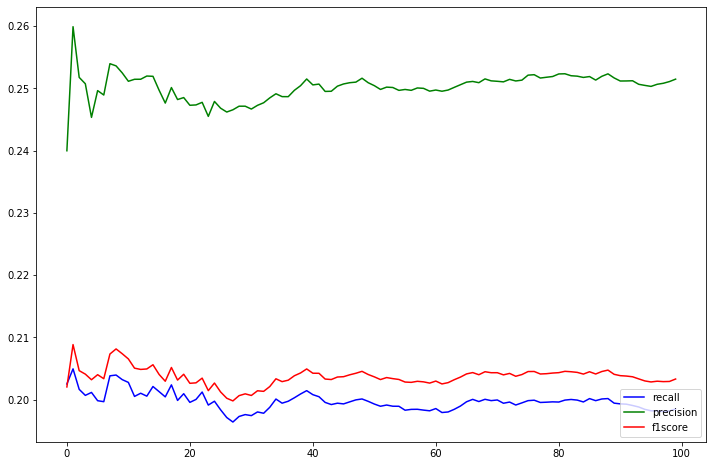

In [33]:
%matplotlib inline 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,1,figsize = (12,8)) 
ax.plot(cumulative_avg_df['recall'], color = 'blue', label = 'recall')
ax.plot(cumulative_avg_df['precision'], color = 'green', label = 'precision')
ax.plot(cumulative_avg_df['f1score'], color = 'red', label = 'f1score')
ax.legend(loc='lower right')

In [34]:
cumulative_avg_df

,recall,precision,f1score
0,0.202514,0.239978,0.202040
1,0.204942,0.259905,0.208843
2,0.201652,0.251763,0.204655
3,0.200684,0.250736,0.204095
4,0.201157,0.245337,0.203195
...,...,...,...
95,0.198207,0.250315,0.202841
96,0.198199,0.250653,0.202959
97,0.198098,0.250815,0.202894
98,0.198169,0.251091,0.202920


In [35]:
cumulative_avg_df.to_csv('cumulative_rouge_avg_exp7.csv', index=False) 
result_df.to_csv('testset_decodedseq_exp7.csv', index=False)

In [39]:
len(beam_result)

84

In [40]:
beam_result_df = pd.concat(beam_result).reset_index(drop=True)

In [41]:
beam_result_df

,gen_summary,ref_summary,rouge_cols,recall,precision,f1score
0,"[light, a, light, candle, .]","[create, a, romantic, mood, by, lighting, cand...","(0.09090909090909091, 0.2, 0.12500000000000003)",0.090909,0.200000,0.125000
1,"[boil, the, mixture, .]","[add, the, chili, and, turmeric, powder, ,, an...","(0.1, 0.25, 0.14285714285714288)",0.100000,0.250000,0.142857
2,"[scrub, the, grout, with, a, toothbrush, .]","[whiten, grout, using, vinegar, and, an, old, ...","(0.25, 0.2857142857142857, 0.26666666666666666)",0.250000,0.285714,0.266667
3,"[be, confident, .]","[imagine, physical, contact]","(0.0, 0.0, 0.0)",0.000000,0.000000,0.000000
4,"[cork, the, cork, .]","[insert, the, knife, into, the, cork, near, th...","(0.125, 0.5, 0.2)",0.125000,0.500000,0.200000
...,...,...,...,...,...,...
8395,"[use, an, aspirin, .]","[take, analgesics, for, fever, and, pain]","(0.0, 0.0, 0.0)",0.000000,0.000000,0.000000
8396,"[teach, your, child, how, to, teach, .]","[repeat, to, encourage, the, learning, process]","(0.16666666666666666, 0.14285714285714285, 0.1...",0.166667,0.142857,0.153846
8397,"[click, on, the, symbol, icon, .]","[look, in, the, left, panel, for, a, computer,...","(0.16666666666666666, 0.3333333333333333, 0.22...",0.166667,0.333333,0.222222
8398,"[make, a, plan, .]","[write, a, clear, couchsurfing, request]","(0.2, 0.25, 0.22222222222222224)",0.200000,0.250000,0.222222


In [42]:
cumulative_list=list(range(100,8500,100))

cumulative_beam_avg = []
for i in cumulative_list: 
    temp = beam_result_df.loc[0:i,'recall':'f1score'].apply(lambda x: np.nanmean(x), axis=0)
    #print(temp)
    cumulative_beam_avg.append({'recall': temp['recall'],'precision': temp['precision'],'f1score': temp['f1score']})

In [47]:
pd.DataFrame(cumulative_beam_avg).to_csv('testset_decoded_beam_exp7_scores.csv', index=False)

In [46]:
beam_result_df.to_csv('testset_decoded_beam_exp7.csv', index=False)

In [ ]:
cumulative_beam_avg 

In [37]:
# now beam search 
chunkholder = list(chunks(range(0, 10000), 100))

beam_result = []
#result_avg = []
for chunk in chunkholder: 
    decode_machine_summary = [beam_decode_sequence(item).split(' ') for item in x_test[chunk]]
    decode_ref_summary = [return_summary(item) for item in y_test[chunk]]
    testset = pd.concat([pd.Series(decode_machine_summary), pd.Series(decode_ref_summary)], axis=1)
    testset.columns = ['gen_summary','ref_summary']
    testset['rouge_cols']=testset.apply(lambda x: rouge_n_sentence_level(x['gen_summary'], x['ref_summary'], 1), axis=1)
    allrouge = testset['rouge_cols'].apply(pd.Series)
    allrouge.columns = ['recall','precision','f1score']
    final = pd.concat([testset,allrouge],axis=1) 
    beam_result.append(final)
    
beam_result_df = pd.concat(beam_result).reset_index(drop=True)

cumulative_list=list(range(100,10100,100))

cumulative_beam_avg = []
for i in cumulative_list: 
    temp = beam_result_df.loc[0:i,'recall':'f1score'].apply(lambda x: np.nanmean(x), axis=0)
    #print(temp)
    cumulative_beam_avg.append({'recall': temp['recall'],'precision': temp['precision'],'f1score': temp['f1score']})

IndexError: list index out of range

In [ ]:
cumulative_beam_avg_df = pd.DataFrame(cumulative_beam_avg).reset_index(drop=True)